In [1]:
import os
import visualpic as vp
import scipy.constants as ct
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
data_path = 'lab_diags/hdf5'
dc = vp.DataContainer('openpmd', data_path)
dc.load_data()
print(' available fields:  ',
        dc.get_list_of_fields(include_derived=True))
print(' available species: ', dc.get_list_of_species())

plotdir = 'Plots'
os.makedirs(plotdir, exist_ok=True)

 available fields:   ['Er', 'Et', 'Ez', 'Ex', 'Ey', 'rho', 'I', 'A', 'a']
 available species:  ['beam']


In [3]:
iteration = 10
# Get Ez
ez_field = dc.get_field('Ez')
ez_data, ez_meta = ez_field.get_data(iteration)
ez_data = ez_data / 1e6
nx, nz = ez_data.shape[0], ez_data.shape[1]
print(f'{nz = } {nx = }')
z_min = ez_meta['axis']['z']['array'][0]
z_max = ez_meta['axis']['z']['array'][-1]
x_min = ez_meta['axis']['r']['array'][0]
x_max = ez_meta['axis']['r']['array'][-1]
# outline
nbins = 2
slice_start = int(nx/2) - int(nbins / 2)
slice_stop = slice_start + nbins
ez_1d = ez_data[slice_start:slice_stop, :]
ez_1d = np.sum(ez_1d, axis=0) / nbins
# print(f'{ez_1d.shape = }')

nz = 6762 nx = 2000


In [4]:
# Get driver density
species = dc.get_species('beam')
datadict = species.get_data(iteration, ['x', 'y', 'z', 'w'])
darray, mdarray = zip(*datadict.values())
x, y, z, w = darray

bins = (500, 1000, 200)
range = [z_min, z_max], [x_min, x_max], [x_min, x_max]
sample = np.vstack((z, x, y)).T
h3d, edges = np.histogramdd(sample, bins=bins, weights=w, range=range)
np0 = 1e21
h3d = h3d / (edges[0][1] - edges[0][0]) / (edges[1][1] - edges[1][0]) / (edges[2][1] - edges[2][0]) / np0

# define central slice
nbins = 2
slice_start = int(h3d.shape[2]/2) - int(nbins / 2)
slice_stop = slice_start + nbins
h2d = h3d[:, :, slice_start:slice_stop]
h2d = np.sum(h2d, axis=2) / nbins
# print(f'{h3d.shape = }')

# current in r<rmax
rmax = 50e-6
mask = np.sqrt(x**2 + y**2) < rmax
sample_c = np.vstack((z[mask], x[mask], y[mask])).T
h3d_c, edges = np.histogramdd(sample_c, bins=bins, weights=w[mask], range=range)
current = np.sum(np.sum(h3d_c, axis=2), axis=1) * ct.e * ct.c / (edges[0][1] - edges[0][0])
print(f'Max. current: {max(current):.1f} A')

Max. current: 4.7 A


In [5]:
colors = [(0.90, 0.90, 0.90), (0.805, 0.835, 0.895), (0.610, 0.670, 0.790),
            (0.415, 0.505, 0.685), (0.220, 0.340, 0.580), (0.390, 0.050, 0.330),
            (0.700, 0.200, 0.300), (0.775, 0.400, 0.275), (0.850, 0.600, 0.250),
            (0.925, 0.800, 0.225), (1.000, 1.000, 0.200)]
cmap = mpl.colors.LinearSegmentedColormap.from_list('electron', colors, N=256)
cmap.set_under('w')

colors = [(0.0, (0.106, 0.078, 0.518)), (0.4, (0.698, 0.818, 0.880)),
          (0.49, (1.0, 1.0, 1.0)), (0.51, (1.0, 1.0, 1.0)),
          (0.6, (0.965, 0.925, 0.353)), (1.0, (0.518, 0.078, 0.106))]
cmap2 = mpl.colors.LinearSegmentedColormap.from_list('field', colors, N=256)

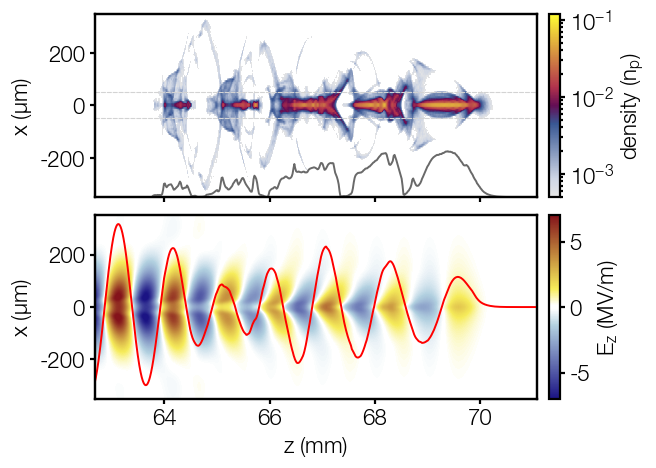

In [6]:
fig = plt.figure(figsize=(6, 5))
grid = mpl.gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[1, 0.025],
                             hspace=0.1, wspace=0.05)

ax1 = fig.add_subplot(grid[0, 0])
extent = [z_min / 1e-3, z_max / 1e-3, x_min / 1e-6, x_max / 1e-6]
img = ax1.imshow(h2d.T, aspect='auto',
                    vmin=5e-4, vmax=1.2e-1,
                    norm='log', 
                    extent=extent, cmap=cmap,
                    rasterized=False)
ax1.set_ylim(-350, 350)
ax1.tick_params(axis='x', which='both', labelbottom=False)
ax1.set_ylabel('$\mathrm{x~(\mu m)}$')
ax1.axhline(rmax / 1e-6, ls='--', c='lightgrey', lw=0.8)
ax1.axhline(-rmax / 1e-6, ls='--', c='lightgrey', lw=0.8)

ax1b = fig.add_subplot(grid[0, 1])
fig.colorbar(img, cax=ax1b, orientation='vertical', label='density ($\mathrm{n_p}$)')

ax1c = ax1.twinx()
z_array = np.r_[z_min/1e-3:z_max/1e-3:len(current)*1j]
ax1c.plot(z_array, current, c='dimgrey')
vmax = np.max(current)
ax1c.set_ylim(0, 4 * vmax)
ax1c.tick_params(axis='y', which='both', right=False, labelright=False)

ax2 = fig.add_subplot(grid[1, 0])
extent = [z_min / 1e-3, z_max / 1e-3, x_min / 1e-6, x_max / 1e-6]
# vmax = 1.0 * np.max(ez_data)
vmax = 7
img = ax2.imshow(ez_data, aspect='auto',
                    vmin=-vmax, vmax=vmax,
                    extent=extent, cmap=cmap2,
                    rasterized=False)
ax2.set_ylim(-350, 350)
ax2.set_xlabel('$\mathrm{z~(mm)}$')
ax2.set_ylabel('$\mathrm{x~(\mu m)}$')
ax2b = fig.add_subplot(grid[1, 1])
fig.colorbar(img, cax=ax2b, orientation='vertical', label='$\mathrm{E_z~(MV/m)}$')

ax2c = ax2.twinx()
z_array = np.r_[z_min/1e-3:z_max/1e-3:len(ez_1d)*1j]
ax2c.plot(z_array, ez_1d, 'r')
ax2c.set_ylim(-vmax, vmax)
ax2c.tick_params(axis='y', which='both', right=False, labelright=False)

plotname = os.path.join(plotdir, 'PITZ_FT_v3-%s.png' % (str(iteration).zfill(4)))
fig.savefig(plotname, dpi=300, bbox_inches='tight')
